In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas_profiling

%matplotlib inline

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Feature Selection based on importance
from sklearn.feature_selection import f_regression

## Error measures
from sklearn import metrics

## Decision tree package:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor 

In [3]:
data = pd.read_excel('C:/Users/ZomAdmin/Desktop/Data Science with python/Python Session 28/MAIN CASE STUDIES - ML/1. Predicting Credit Card Spend & Identifying Key Drivers/Data Set.xlsx')

In [4]:
data.shape

(5000, 130)

In [5]:
data.info() ## Data consist 5k rows and 130 columns:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [7]:
data.columns

Index(['custid', 'region', 'townsize', 'gender', 'age', 'agecat', 'birthmonth',
       'ed', 'edcat', 'jobcat',
       ...
       'owncd', 'ownpda', 'ownpc', 'ownipod', 'owngame', 'ownfax', 'news',
       'response_01', 'response_02', 'response_03'],
      dtype='object', length=130)

In [8]:
profiling_data=pandas_profiling.ProfileReport(data)
profiling_data.to_file("profiling_data.html")

## Seggragating continous and categorical data 

##### Categorical vairables

In [4]:
Cat_var = data[['region','townsize','gender','agecat','birthmonth','edcat','jobcat','union','employ','empcat','retire','inccat',
      'default','jobsat','marital','spousedcat','homeown','hometype','address','addresscat','cars','carown','cartype',
      'carcatvalue','carbought','carbuy','commute','commutecat','commutecar','commutemotorcycle','commutecarpool','commutebus',
      'commuterail','commutepublic','commutebike','commutewalk','commutenonmotor','telecommute','reason','polview','polparty',
      'polcontrib','vote','card','cardtype','cardbenefit','cardfee','cardtenure','cardtenurecat','card2','card2type',
      'card2benefit','card2fee','card2tenure','card2tenurecat','active','bfast','churn','tollfree','equip','callcard','wireless',
      'multline','voice','pager','internet','callid','callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd',
      'ownpda','ownpc','ownipod','owngame','ownfax','news','response_01','response_02','response_03']]

##### Continous variables

In [5]:
cont_var = data[['age','ed','income','lninc','debtinc','creddebt','lncreddebt','othdebt','lnothdebt','spoused','reside','pets','pets_cats',
'pets_dogs','pets_birds','pets_reptiles','pets_small','pets_saltfish','pets_freshfish','carvalue','commutetime','cardspent',
     'card2spent','tenure','longmon','lnlongmon','longten','lnlongten','tollmon','lntollmon','tollten','lntollten','hourstv',
     'equipmon','lnequipmon','equipten','lnequipten','cardmon','lncardmon','cardten','lncardten','wiremon','lnwiremon','wireten'
      ,'lnwireten']]

In [6]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [8]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [9]:
# Create Data audit Report for categorical variables
def categorical_var_summary( x ):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [10]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

# EDA - Exploratory data analysis

In [13]:
cont_var.apply(lambda x:continuous_var_summary(x))

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,...,equipten,lnequipten,cardmon,lncardmon,cardten,lncardten,wiremon,lnwiremon,wireten,lnwireten
N,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4999.000000,5000.000000,4999.000000,5000.000000,...,5.000000e+03,1704.000000,5000.000000,3581.000000,4.998000e+03,3578.000000,5000.000000,1344.000000,5.000000e+03,1344.000000
NMISS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000e+00,3296.000000,0.000000,1419.000000,2.000000e+00,1422.000000,0.000000,3656.000000,0.000000e+00,3656.000000
SUM,235128.000000,72715.000000,273798.000000,18499.546992,49770.800000,9286.628229,-652.137155,18272.300771,3483.879384,30564.000000,...,2.350882e+06,11497.393056,77219.250000,10419.752778,3.600951e+06,22993.332638,53505.950000,4845.120915,2.109923e+06,9150.129457
MEAN,47.025600,14.543000,54.759600,3.699909,9.954160,1.857326,-0.130454,3.654460,0.696915,6.112800,...,4.701764e+02,6.747296,15.443850,2.909733,7.204784e+02,6.426309,10.701190,3.605001,4.219846e+02,6.808132
MEDIAN,47.000000,14.000000,38.000000,3.637586,8.800000,0.926437,-0.076106,2.098540,0.741537,-1.000000,...,0.000000e+00,7.050556,13.750000,2.904165,4.250000e+02,6.639876,0.000000,3.597997,0.000000e+00,7.147185
STD,17.770338,3.281083,55.377511,0.747072,6.399783,3.415732,1.273058,5.395172,1.128578,7.743518,...,9.122206e+02,1.199234,15.007569,0.564859,9.222255e+02,1.172050,19.799837,0.390102,1.001003e+03,1.283967
VAR,315.784902,10.765504,3066.668742,0.558116,40.957226,11.667225,1.620678,29.107876,1.273689,59.962069,...,8.321465e+05,1.438161,225.227130,0.319066,8.504999e+05,1.373700,392.033527,0.152179,1.002008e+06,1.648571
MIN,18.000000,6.000000,9.000000,2.197225,0.000000,0.000000,-6.597334,0.000000,-4.092107,-1.000000,...,0.000000e+00,2.489065,0.000000,1.178655,0.000000e+00,1.558145,0.000000,2.541602,0.000000e+00,2.541602
P1,18.000000,8.000000,9.000000,2.197225,0.700000,0.033160,-3.401690,0.114299,-2.168241,-1.000000,...,0.000000e+00,3.169937,0.000000,1.658228,0.000000e+00,2.484907,0.000000,2.806811,0.000000e+00,3.039749
P5,20.000000,9.000000,13.000000,2.564949,1.900000,0.101088,-2.291604,0.287692,-1.243483,-1.000000,...,0.000000e+00,4.251230,0.000000,1.981001,0.000000e+00,4.094345,0.000000,2.992964,0.000000e+00,4.114134


In [12]:
cont_var_description = cont_var.apply(lambda x:continuous_var_summary(x)) ## We have detected outliers here:

In [14]:
cont_var_description.to_csv('cont_var_description.csv',header = True)

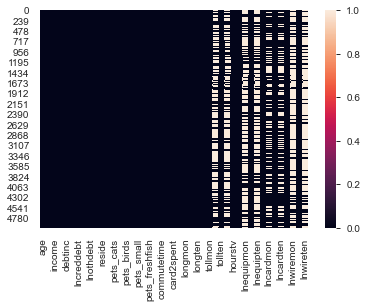

In [15]:
sns.heatmap(cont_var.isna()) ## We can see there are large number of variables who have missing values:

### Outlier Treatment

In [17]:
cont_var = cont_var.apply(lambda x: x.clip(lower = x.quantile(0.01),upper = x.quantile(0.99))) ## Here we have treated the outliers

In [18]:
cont_var.to_csv('cont_var.csv',header = True)

In [17]:
cont_var.apply(continuous_var_summary) ## Now we can see that outliers have been treated:

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,...,equipten,lnequipten,cardmon,lncardmon,cardten,lncardten,wiremon,lnwiremon,wireten,lnwireten
N,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4999.000000,5000.000000,4999.000000,5000.000000,...,5.000000e+03,1704.000000,5000.000000,3581.000000,4.998000e+03,3578.000000,5000.000000,1344.000000,5.000000e+03,1344.000000
NMISS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000e+00,3296.000000,0.000000,1419.000000,2.000000e+00,1422.000000,0.000000,3656.000000,0.000000e+00,3656.000000
SUM,235128.000000,72721.000000,268149.500000,18485.246078,49570.600000,8791.844708,-638.770486,17612.530669,3491.232703,30477.000000,...,2.316992e+06,11498.329814,76334.750000,10417.422617,3.534781e+06,23004.958941,52651.350000,4844.080103,2.049800e+06,9150.154882
MEAN,47.025600,14.544200,53.629900,3.697049,9.914120,1.758369,-0.127780,3.522506,0.698386,6.095400,...,4.633984e+02,6.747846,15.266950,2.909082,7.072391e+02,6.429558,10.530270,3.604226,4.099600e+02,6.808151
MEDIAN,47.000000,14.000000,38.000000,3.637586,8.800000,0.926437,-0.076106,2.098540,0.741537,-1.000000,...,0.000000e+00,7.050556,13.750000,2.904165,4.250000e+02,6.639876,0.000000,3.597997,0.000000e+00,7.147185
STD,17.770338,3.242553,46.567698,0.738495,6.241691,2.380681,1.241398,4.221760,1.104530,7.709565,...,8.828328e+02,1.190092,14.156339,0.555100,8.483399e+02,1.146504,19.021280,0.382289,9.300074e+02,1.273410
VAR,315.784902,10.514149,2168.550537,0.545375,38.958700,5.667644,1.541068,17.823256,1.219987,59.437386,...,7.793938e+05,1.416320,200.401931,0.308136,7.196806e+05,1.314471,361.809101,0.146145,8.649138e+05,1.621573
MIN,18.000000,8.000000,9.000000,2.197225,0.700000,0.033160,-3.401690,0.114299,-2.168241,-1.000000,...,0.000000e+00,3.169937,0.000000,1.658228,0.000000e+00,2.484907,0.000000,2.806811,0.000000e+00,3.039749
P1,18.000000,8.000000,9.000000,2.197225,0.700000,0.033166,-3.401599,0.114312,-2.168229,-1.000000,...,0.000000e+00,3.170180,0.000000,1.658228,0.000000e+00,2.484907,0.000000,2.810508,0.000000e+00,3.039749
P5,20.000000,9.000000,13.000000,2.564949,1.900000,0.101088,-2.291604,0.287692,-1.243483,-1.000000,...,0.000000e+00,4.251230,0.000000,1.981001,0.000000e+00,4.094345,0.000000,2.992964,0.000000e+00,4.114134


### Treatment of missing values:

In [ ]:
cont_var.isna().sum().sort_values(ascending = False).head(15) 
## We see that some of the columns have high number of missing values

In [26]:
missing_variables = cont_var.isna().sum().sort_values(ascending = False).head(15) 

In [28]:
missing_variables = pd.DataFrame({'Variables':missing_variables})

In [30]:
missing_variables.to_csv('missing_variables.csv',header = True)

### We can see that some of the columns have more than 70% data as missing value hence we can drop those columns

In [31]:
pd.DataFrame(cont_var.isna().sum() *100 / cont_var.isna().count()).sort_values(0,ascending = False)

,0
lnwireten,73.12
lnwiremon,73.12
lnequipten,65.92
lnequipmon,65.92
lntollten,52.44
lntollmon,52.44
lncardten,28.44
lncardmon,28.38
longten,0.06
lnlongten,0.06


### Here we have dropped the columns with high number of missing values

In [32]:
cont_var.drop(columns = ['lnwireten','lnwiremon','lnequipten','lnequipmon','lntollten','lntollmon','lncardten','lncardmon'],
             axis = 1,inplace = True)

### Imputing values with mean for rest of the missing values columns

In [33]:
cont_var = cont_var.apply(lambda x:missing_imputation(x))

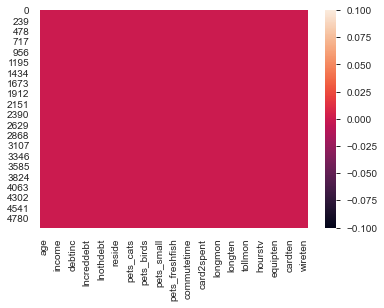

In [34]:
sns.heatmap(cont_var.isna()) ## Now we can see missing values have been imputed with mean:

## Target Variable or Y variable

In [35]:
cont_var['spending']=cont_var.cardspent + cont_var.card2spent ## Here we have created target variable

## No missing value in our Target Variable

In [36]:
cont_var.spending.isna().sum() 

0

## Dummy variables

### Here we have created dummy variables with categorical features

In [37]:
for c_feature in Cat_var.columns:
    
    Cat_var[c_feature] = Cat_var[c_feature].astype('category')
    
    Cat_var = create_dummies(Cat_var, c_feature) 

C:\Users\ZomAdmin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
Cat_var

,region_2,region_3,region_4,region_5,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,gender_1,agecat_3,...,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,1,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0,0,...,1,1,1,1,1,1,1,0,0,0
2,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,1,1,1,0,1,1,0,0
4,1,0,0,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4996,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4997,0,0,1,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,1,0,0,0


## Forming dataset

In [39]:
final_data = pd.concat([cont_var,Cat_var],axis=1)

In [40]:
final_data.shape ## Our final data has 5k rows and 394 columns

(5000, 394)

In [41]:
final_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 394 entries, age to response_03_1
dtypes: float64(24), int64(14), uint8(356)
memory usage: 3.1 MB


In [42]:
final_data.to_csv('final_data.csv',header = True)

## Assumption 1 - Y should be normally distributed or errors should be normally distributed

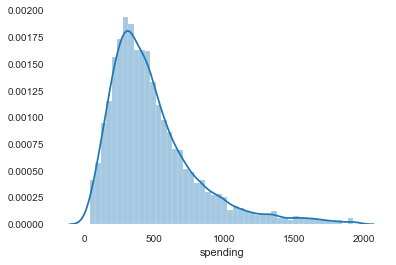

In [43]:
sns.distplot(final_data.spending) ## We can see y is bit positive skewed 

### QQ plot for normality check

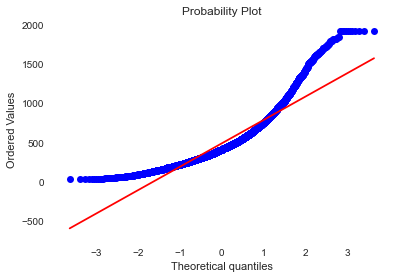

In [44]:
stats.probplot(final_data.spending, dist = 'norm',plot = plt)
plt.show()

In [45]:
final_data.spending.skew() ## Positively skewed 

1.5894777645599651

## Log transformation

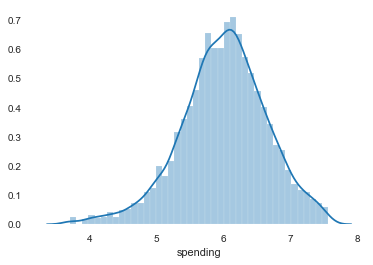

In [46]:
sns.distplot(np.log(final_data.spending)) ## Close to normal distribution

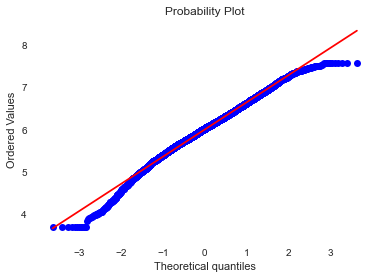

In [47]:
stats.probplot(np.log(final_data.spending), dist = 'norm',plot = plt) ## Now this is close to normal dist
plt.show()

In [48]:
np.log(final_data.spending).skew() ## Close to normal dist

-0.33833191076128283

### Here we have saved Y variable after log transformation

In [49]:
final_data['log_spending'] = np.log(final_data.spending) 

In [51]:
Y_variable = final_data[['spending','log_spending']]

In [52]:
Y_variable.to_csv('Y_variable.csv',header = True)

## Assumption 2 -  Independent variable should have linear relationship with dependent variable

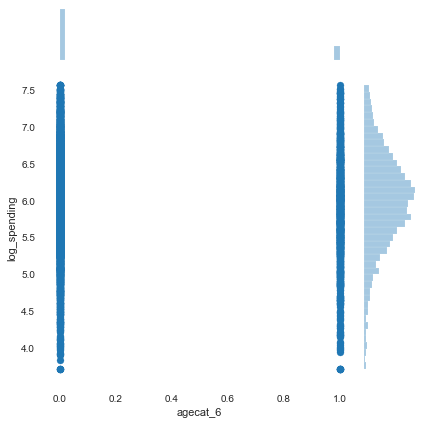

In [37]:
sns.jointplot(final_data.agecat_6,final_data.log_spending)

### Here we have renamed few variables

In [53]:
final_data.rename({'townsize_2.0':'townsize_2','townsize_3.0':'town_size_3'},axis=1,inplace = True)

In [54]:
final_data.rename({'townsize_4.0':'townsize_4','townsize_5.0':'town_size_5'},axis = 1,inplace = True)

# CORELATION

## Columns having corr value with respect to target variable greater then 0.1 or less than -0.075 have been saved, rest were removed.


In [55]:
cor = final_data.corr()
cor

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,...,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1,log_spending
age,1.000000,-0.093966,0.208287,0.142984,0.039031,0.142401,0.108046,0.154514,0.127005,-0.002796,...,-0.074423,-0.133284,-0.217524,-0.235226,-0.042090,0.365204,0.015140,0.013175,-0.026231,0.005798
ed,-0.093966,1.000000,0.186802,0.206332,0.013871,0.122362,0.129920,0.135869,0.154458,0.113928,...,0.300016,0.435623,0.369831,0.377019,0.276163,-0.073510,-0.117333,0.073750,0.107912,0.098166
income,0.208287,0.186802,1.000000,0.898175,0.011586,0.627577,0.531252,0.696227,0.597842,0.035491,...,0.145061,0.049270,0.032922,0.040452,0.149388,0.138730,-0.002440,0.062896,0.053011,0.355694
lninc,0.142984,0.206332,0.898175,1.000000,0.013177,0.566972,0.583808,0.636801,0.666061,0.045417,...,0.155503,0.057608,0.061468,0.060089,0.146191,0.108047,-0.001206,0.061287,0.060666,0.405218
debtinc,0.039031,0.013871,0.011586,0.013177,1.000000,0.462599,0.552941,0.526967,0.628006,-0.040150,...,0.000553,0.008897,0.014713,0.005524,0.003251,0.005278,0.006831,0.003684,0.019776,0.015695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
news_1,0.365204,-0.073510,0.138730,0.108047,0.005278,0.084178,0.058396,0.103931,0.076190,0.090556,...,-0.037949,-0.061753,-0.099716,-0.089811,-0.024573,1.000000,0.020919,0.030136,-0.011148,0.028816
response_01_1,0.015140,-0.117333,-0.002440,-0.001206,0.006831,0.000131,-0.002961,0.008473,0.007010,-0.007956,...,-0.023472,-0.107194,-0.069870,-0.096176,-0.014592,0.020919,1.000000,-0.015601,-0.018781,-0.008874
response_02_1,0.013175,0.073750,0.062896,0.061287,0.003684,0.029992,0.025132,0.052684,0.049590,0.032120,...,0.021608,0.039891,0.015485,0.011744,0.032549,0.030136,-0.015601,1.000000,0.028266,0.027171
response_03_1,-0.026231,0.107912,0.053011,0.060666,0.019776,0.040907,0.054076,0.041894,0.045314,0.001544,...,0.077116,0.089388,0.072791,0.094278,0.093360,-0.011148,-0.018781,0.028266,1.000000,0.061761


In [56]:
cor.to_csv('cor.csv',header = True)

In [57]:
cor = pd.DataFrame(cor['log_spending'])
c1 = cor[cor['log_spending'] > 0.1]
c2 = cor[cor['log_spending'] < -0.075]
c3 = pd.concat([c1,c2],axis=0)
c3.reset_index(inplace=True)
c3.columns = ['col','value']
credit_new = final_data[c3.col]
credit_new

,income,lninc,creddebt,lncreddebt,othdebt,lnothdebt,carvalue,cardspent,card2spent,spending,...,owncd_1,log_spending,gender_1,agecat_6,retire_1,carown_0,carcatvalue_1,card_2,card_3,card2_3
0,31.0,3.433987,1.200909,0.183079,2.240091,0.806516,14.30000,81.66,67.80,149.46,...,0,5.007029,1,0,0,0,1,0,1,0
1,15.0,2.708050,1.222020,0.200505,1.567980,0.449788,6.80000,42.60,34.94,77.54,...,1,4.350794,0,0,0,0,1,1,0,0
2,35.0,3.555348,0.928620,-0.074056,2.536380,0.930738,18.80000,184.22,175.75,359.97,...,1,5.886021,1,1,0,0,1,1,0,0
3,20.0,2.995732,0.033166,-3.401599,1.117200,0.110826,8.70000,340.99,18.42,359.41,...,1,5.884464,0,0,0,0,1,1,0,1
4,23.0,3.135494,0.214659,-1.538705,0.176341,-1.735336,10.60000,255.10,252.73,507.83,...,1,6.230147,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,196.0,5.278115,7.934080,2.071167,7.745920,2.047166,64.50000,872.11,553.56,1425.67,...,1,7.262397,0,1,0,0,0,0,0,1
4996,83.0,4.418841,3.336600,1.204952,9.113400,2.209746,40.00000,210.81,155.54,366.35,...,1,5.903589,0,0,0,0,0,0,1,0
4997,108.0,4.682131,3.557520,1.269064,8.106480,2.092664,53.60000,884.08,643.67,1527.75,...,1,7.331551,0,1,0,0,0,0,0,0
4998,189.0,5.241747,5.021352,1.613699,15.390648,2.733760,92.00001,381.35,371.60,752.95,...,1,6.623999,0,0,0,0,0,0,1,0


# F_REGRESSION

In [58]:
features=credit_new.columns.difference(['log_spending'])

In [59]:
variables=final_data[features]
target=final_data.log_spending

In [60]:
col_ser=pd.Series(variables.columns)

In [61]:
# do the f_regression
F_values, p_values  = f_regression( variables, target )
# combine the output in dataframe
F_regression_op = pd.DataFrame([col_ser, F_values.round(2), p_values.round()]).T

# add the column names
F_regression_op.columns = ['Features', 'F_values', 'p_values', ]

In [62]:
F_regression_op

,Features,F_values,p_values
0,agecat_5,57.9,0
1,agecat_6,47.17,0
2,carcatvalue_1,438.28,0
3,carcatvalue_3,361.75,0
4,card2_3,38.55,0
5,card2spent,6786.69,0
6,card_2,72.73,0
7,card_3,60.69,0
8,cardspent,13556.3,0
9,carown_0,135.37,0


## Assumption 3 - X variables should not have relationship with each other they should only be related to Y (There should be less multicolinearity)

### High VIF of the variable means information in that variable has already been explained by other X variables present in the model

In [63]:
'+'.join(col_ser)

'agecat_5+agecat_6+carcatvalue_1+carcatvalue_3+card2_3+card2spent+card_2+card_3+cardspent+carown_0+carown_1+carvalue+creddebt+gender_1+inccat_3+inccat_4+inccat_5+income+lncreddebt+lninc+lnothdebt+othdebt+owncd_1+owndvd_1+ownvcr_1+reason_2+retire_1+spending'

In [64]:
model_param = 'log_spending ~ ' + ' + '.join(col_ser)
# separate the Y and X variables
y, X = dmatrices( model_param, final_data, return_type = 'dataframe' )

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()

vif['Features'] = X.columns
vif['VIF_Factor'] = [ variance_inflation_factor(X.values, i) for i in range(X.shape[1]) ]

# display the output
vif.round(1).head(1)

C:\Users\ZomAdmin\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,VIF_Factor
0,Intercept,286.0


In [65]:
vif.sort_values('VIF_Factor',ascending = False)

,Features,VIF_Factor
28,spending,inf
6,card2spent,inf
9,cardspent,inf
0,Intercept,285.989626
18,income,19.447382
20,lninc,17.909658
12,carvalue,14.650935
11,carown_1,8.230252
17,inccat_5,7.977975
10,carown_0,6.299564


## 2nd Iteration for VIF to remove some insignificant variables

In [66]:
prama='''log_spending ~ agecat_5+carcatvalue_1+card2_3+card_2+card_3+carown_0+gender_1+inccat_3+inccat_4+lncreddebt+othdebt+owncd_1+owndvd_1+ownvcr_1+reason_2+retire_1+spending'''

In [67]:
y, X = dmatrices( prama, final_data, return_type = 'dataframe' )

# For each X, calculate VIF and save in dataframe
vif2 = pd.DataFrame()

vif2['Features'] = X.columns
vif2['VIF_Factor'] = [ variance_inflation_factor(X.values, i) for i in range(X.shape[1]) ]

# display the output
vif2.round(1).head(1)

,Features,VIF_Factor
0,Intercept,34.1


In [68]:
vif2.sort_values('VIF_Factor',ascending = False)

,Features,VIF_Factor
0,Intercept,34.138360
2,carcatvalue_1,1.943682
11,othdebt,1.628097
10,lncreddebt,1.600237
14,ownvcr_1,1.507366
12,owncd_1,1.458576
13,owndvd_1,1.455402
8,inccat_3,1.387105
9,inccat_4,1.375296
5,card_3,1.277943


In [69]:
vif2.count()

Features      18
VIF_Factor    18
dtype: int64

In [71]:
vif2.to_csv('vif2.csv',header = True)

In [72]:
feature_columns2 = list(set(vif2.loc[:, 'Features']).difference(['Intercept']))

In [75]:
Final_x_variables = pd.DataFrame({'Final_Features':feature_columns2})

In [76]:
Final_x_variables.to_csv('Final_x_variables.csv',header = True)

# Model Building

In [77]:
train,test=train_test_split(final_data,test_size = 0.3,random_state=2)

In [78]:
param='log_spending ~ '+'+'.join(feature_columns2)

In [79]:
modelone=smf.ols(param,train).fit()

In [80]:
print(modelone.summary())

                            OLS Regression Results                            
Dep. Variable:           log_spending   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     1010.
Date:                Thu, 27 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:54:16   Log-Likelihood:                -386.22
No. Observations:                3500   AIC:                             808.4
Df Residuals:                    3482   BIC:                             919.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.0293      0.027    185.659

## We can see there is difference between R2 and Adjr2

In [81]:
modelone.rsquared

0.8313802984979466

In [82]:
modelone.rsquared_adj

0.8305570546939446

## Predictions

In [83]:
# verify the no of obs in training and testing after split

print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  3500  |  No of obs in testing:  1500


## Predicting spend pn training data

In [84]:
# Step 4: predict the sales on the training data
train['pred_spend'] = np.exp(modelone.predict(train))

C:\Users\ZomAdmin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
train[['spending','pred_spend']]

,spending,pred_spend
2416,600.97,462.421990
2417,604.09,553.138899
2513,517.89,454.308710
1698,748.64,689.435146
3322,431.36,341.829299
...,...,...
3335,191.20,206.586083
1099,656.33,557.958789
2514,238.29,259.661752
3606,302.56,294.728212


In [86]:
# Step 5: predict the sales on the testing/validation data
test['pred_spend'] = np.exp(modelone.predict(test))

C:\Users\ZomAdmin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [87]:
test[['spending','pred_spend']]

,spending,pred_spend
3566,499.15,412.252822
4252,407.08,344.577356
1918,232.08,255.650951
4111,231.82,246.989238
1471,256.02,261.203730
...,...,...
570,204.63,253.126931
4853,295.04,278.527817
768,144.77,192.674916
2085,588.32,457.484175


## Model evaluation and accuracy measures

### Mean Errors

In [89]:
train[['spending','pred_spend']].mean() ## We can see that means are different for both the variables hence there are errors:

spending      494.620505
pred_spend    517.058315
dtype: float64

In [90]:
test[['spending','pred_spend']].mean() ## We can see that means are different for both the variables hence there are errors:

spending      486.637923
pred_spend    496.486035
dtype: float64

### MSE and RMSE

In [91]:
from sklearn import metrics

In [94]:
mse_train = metrics.mean_squared_error(train.spending,train.pred_spend)
mse_test=metrics.mean_squared_error(test.spending,test.pred_spend)
#------------------------------------------------------------
RMSE_train=np.sqrt(mse_train)
RMSE_test=np.sqrt(mse_test)

print('MSE_Train',mse_train,'|','RMSE_Train',RMSE_train)
print('MSE_Test',mse_test,'|','RMSE_Test',RMSE_test)

MSE_Train 100131.93779968274 | RMSE_Train 316.43630923091416
MSE_Test 80671.30639209539 | RMSE_Test 284.0269465950289


### Correlation

### Here we are seeing that errors are high for the majority of data

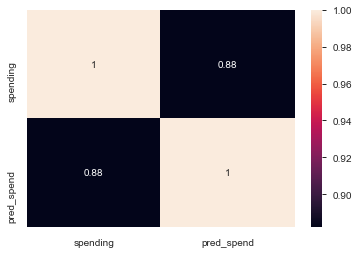

In [95]:
sns.heatmap(train[['spending','pred_spend']].corr(),annot = True)

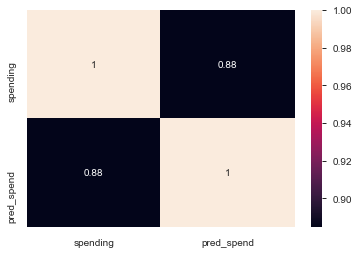

In [90]:
sns.heatmap(test[['spending','pred_spend']].corr(),annot = True)

## Scatter plots

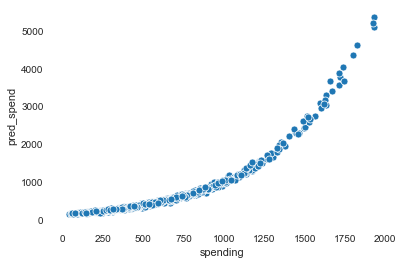

In [92]:
sns.scatterplot(test.spending,test.pred_spend) ## Straight line is tilting downwards due to high number of errors

### Here we can see that errors are high our model is predicting more than double values in predictions 

## MAE AND MAPE - Mean absolute error and Mean absolute percentage Error

In [96]:
# Step 6: accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAE_TRAIN = metrics.mean_absolute_error(train.spending,train.pred_spend)
MAE_TEST = metrics.mean_absolute_error(test.spending,test.pred_spend)

MAPE_train = '%.3f' % np.mean(np.abs(train['spending'] - train['pred_spend'])/train['spending'])
MAPE_test = '%.3f' % np.mean(np.abs(test['spending'] - test['pred_spend'])/test['spending'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)
print('MAE_TRAIN',MAE_TRAIN,'|','MAE_TEST',MAE_TEST)

MAPE of training data:  0.222  |  MAPE of testing data:  0.203
MAE_TRAIN 112.82098334862994 | MAE_TEST 104.59977683578428


## Decile analysis

### We can see that our output is not good directionally errors are very high on almost each decile

In [97]:
test['Deciles'] = pd.qcut(test.pred_spend,10,labels = False)

C:\Users\ZomAdmin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [100]:
test.groupby('Deciles')[['spending','pred_spend']].mean().sort_index(ascending = False).reset_index()

,Deciles,spending,pred_spend
0,9,1194.386303,1662.768506
1,8,759.240133,665.456975
2,7,595.506400,494.405456
3,6,514.385600,421.918455
4,5,438.264800,371.165365
5,4,382.083467,330.651759
6,3,327.907800,297.915851
7,2,282.210467,272.075248
8,1,228.701867,245.400824
9,0,143.692393,203.101914


In [99]:
deciles_Linear_regression_model = test.groupby('Deciles')[['spending','pred_spend']].mean().sort_index(ascending = False).reset_index()

In [101]:
deciles_Linear_regression_model.to_csv('deciles_Linear_regression_model.csv',header = True)

### Lets check that our errors are normally distributed or not

In [102]:
test['errors']=test.spending - test.pred_spend

C:\Users\ZomAdmin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


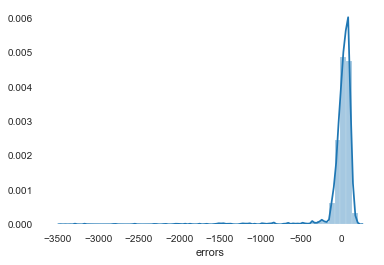

In [103]:
sns.distplot(test.errors)

## Assumption 4 - Errors should be homoscedastic accross different values of Y

### Here we can see that errors are homoscedastic across the Y there is no heteroscedasticity present in errors

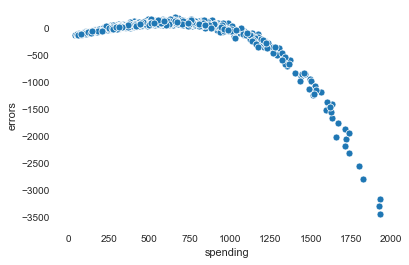

In [104]:
sns.scatterplot(test.spending,test.errors)

## Assumption 5 - There should not be any autocorrelation in errors

### Via this model our durbin watson is coming under 10% of 2 ( Durbin-Watson:  2.022) hence we can say that autocorrelation is not present in errors

<center>
<h1> Decision Tree

### CART MSE - CLASSIFICATION AND REGRESSION TREES FOR MEAN SQUARED ERRORS

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

In [106]:
dtr = DecisionTreeRegressor()

In [107]:
param_grid={'max_depth':np.arange(1,4),
'max_features':np.arange(1,19),
'criterion':['mse']}

In [108]:
tree_reg = GridSearchCV(dtr,param_grid,cv=10)

In [109]:
tree_reg.fit(train[feature_columns2],train.log_spending)

C:\Users\ZomAdmin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\ZomAdmin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\ZomAdmin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\ZomAdmin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['mse'], 'max_depth': array([1, 2, 3]),
                         'max_features': array([ 1,  2,  3,  4,  5,  6,  7, 

In [110]:
tree_reg.best_params_  ## Here we are getting best parameters to build model on 

{'criterion': 'mse', 'max_depth': 3, 'max_features': 17}

In [111]:
tree_hyped = DecisionTreeRegressor(criterion='mse',max_depth=3,max_features=17)

In [112]:
tree_hyped.fit(train[feature_columns2],train.log_spending)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=17, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [113]:
# Step 4: predict the sales on the training data
train_decision = pd.DataFrame({'Actual':train.spending,'predicted':np.exp(tree_hyped.predict(train[feature_columns2]))})

In [114]:
test_decision = pd.DataFrame({'Actual':test.spending,'predicted':np.exp(tree_hyped.predict(test[feature_columns2]))})

In [115]:
test_decision.head(5)

,Actual,predicted
3566,499.15,446.147748
4252,407.08,446.147748
1918,232.08,223.203793
4111,231.82,223.203793
1471,256.02,223.203793


In [116]:
train_decision.head(5)

,Actual,predicted
2416,600.97,606.719068
2417,604.09,606.719068
2513,517.89,446.147748
1698,748.64,854.880402
3322,431.36,446.147748


## Decision tree model evaluation

## Mean errors

In [117]:
train_decision.mean()

Actual       494.620505
predicted    491.220056
dtype: float64

In [118]:
test_decision.mean()

Actual       486.637923
predicted    484.828622
dtype: float64

## MSE and RMSE

In [119]:
mse_train = metrics.mean_squared_error(train_decision.Actual,train_decision.predicted)
mse_test=metrics.mean_squared_error(test_decision.Actual,test_decision.predicted)
#------------------------------------------------------------
RMSE_train=np.sqrt(mse_train)
RMSE_test=np.sqrt(mse_test)

print('MSE',mse_train,'|','RMSE',RMSE_train)
print('MSE',mse_test,'|','RMSE',RMSE_test)

MSE 5921.52358719529 | RMSE 76.95143655056279
MSE 5143.775302546279 | RMSE 71.72011783695199


## MAE AND MAPE - Mean absolute error and Mean absolute percentage Error

In [120]:
# Step 6: accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAE_TRAIN_dec = metrics.mean_absolute_error(train_decision.Actual,train_decision.predicted)
MAE_TEST_dec = metrics.mean_absolute_error(test_decision.Actual,test_decision.predicted)

MAPE_train = '%.3f' % np.mean(np.abs(train_decision['Actual'] - train_decision['predicted'])/train_decision['Actual'])
MAPE_test = '%.3f' % np.mean(np.abs(test_decision['Actual'] - test_decision['predicted'])/test_decision['Actual'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)
print('MAE_TRAIN',MAE_TRAIN_dec,'|','MAE_TEST',MAE_TEST_dec)

MAPE of training data:  0.097  |  MAPE of testing data:  0.094
MAE_TRAIN 48.15988964869077 | MAE_TEST 45.955606913767795


## Scatter plot

### Model has less errors as compared to linear regression

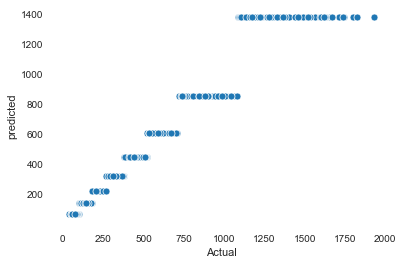

In [122]:
sns.scatterplot(test_decision.Actual,test_decision.predicted)

## Correlation matrix

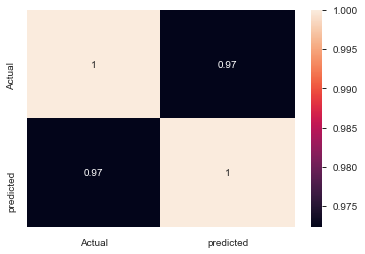

In [124]:
sns.heatmap(test_decision[['Actual','predicted']].corr(),annot = True)

## Decile analysis for testing data

In [122]:
test_decision['deciles'] = pd.qcut(test_decision.predicted,10,labels = False,duplicates='drop')

In [123]:
test_decision.head(1)

,Actual,predicted,deciles
3566,499.15,446.147748,2


## Here we can see that output is still directionally unstable for last 5 deciles

In [126]:
test_decision.groupby('deciles')[['Actual','predicted']].mean().sort_index(ascending = False).reset_index()

,deciles,Actual,predicted
0,5,1378.963918,1382.324721
1,4,869.799695,854.880402
2,3,602.930992,606.719068
3,2,446.530613,446.147748
4,1,322.248967,321.635002
5,0,190.411629,186.771507


In [125]:
deciles_decision_tree_model = test_decision.groupby('deciles')[['Actual','predicted']].mean().sort_index(ascending = False).reset_index()

In [127]:
deciles_decision_tree_model.to_csv('deciles_decision_tree_model.csv',header = True)

<center>
<h1> Bagging

In [130]:
from sklearn.ensemble import BaggingRegressor

In [131]:
BaggingRegressor()

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [132]:
param_grid={'n_estimators':[100,200,300,400],
'max_samples':[0.9,0.8,0.7,0.6],}

#### Running BaggingRegressor for regression, keeping warm_start = True so that our model will retain last iteration and will do incremental 100 in every next iteration

In [133]:
bagg_reg = GridSearchCV(BaggingRegressor(warm_start=True),param_grid,cv = 5)

In [134]:
bagg_reg.fit(train[feature_columns2],train.log_spending)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
                                        bootstrap_features=False,
                                        max_features=1.0, max_samples=1.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=True),
             iid='deprecated', n_jobs=None,
             param_grid={'max_samples': [0.9, 0.8, 0.7, 0.6],
                         'n_estimators': [100, 200, 300, 400]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [135]:
bagg_reg.best_params_ ## These are the best parameters for our bagging model:

{'max_samples': 0.9, 'n_estimators': 300}

In [136]:
bag_reg = BaggingRegressor(max_samples = 0.9,n_estimators=200)

In [137]:
bag_reg.fit(train[feature_columns2],train.log_spending)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=0.9, n_estimators=200,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

### Predictions 

In [138]:
train_bagging = pd.DataFrame({'Actual':train.spending,'predicted':np.exp(bag_reg.predict(train[feature_columns2]))})
test_bagging = pd.DataFrame({'Actual':test.spending,'predicted':np.exp(bag_reg.predict(test[feature_columns2]))})

In [139]:
test_bagging.head(10)

,Actual,predicted
3566,499.15,499.247355
4252,407.08,406.994148
1918,232.08,232.294068
4111,231.82,232.038684
1471,256.02,255.934625
929,194.58,194.415638
1916,229.03,229.076237
3995,310.54,310.566468
1130,135.92,135.932734
1723,339.72,339.971425


In [140]:
train_bagging.head(10)

,Actual,predicted
2416,600.97,600.993867
2417,604.09,604.240815
2513,517.89,517.718584
1698,748.64,748.438306
3322,431.36,431.360947
4133,539.05,539.156791
3116,927.19,926.874538
614,237.93,237.878888
2342,214.36,214.307156
1161,595.96,595.951745


## Bagging model evaluation

In [145]:
train_bagging.mean() ## Not much difference among the mean values hence errors are stable 

Actual       494.620755
predicted    494.616875
dtype: float64

In [146]:
test_bagging.mean()

Actual       486.638215
predicted    486.642564
dtype: float64

## MSE AND RMSE - Mean Squared Errors and Root Mean Squared Errors

In [147]:
mse_train = metrics.mean_squared_error(train_bagging.Actual,train_bagging.predicted)
mse_test=metrics.mean_squared_error(test_bagging.Actual,test_bagging.predicted)
#------------------------------------------------------------
RMSE_train=np.sqrt(mse_train)
RMSE_test=np.sqrt(mse_test)

print('MSE',mse_train,'|','RMSE',RMSE_train)
print('MSE',mse_test,'|','RMSE',RMSE_test)

MSE 0.1913981150613063 | RMSE 0.4374907028284216
MSE 0.5066013590910696 | RMSE 0.7117593407122028


## Mae and Mape - Mean absolute error and Mean absolute percentage error

### We can see that MAPE value for training and testing are very low hence we can say that our model is explaining(reducing) high number of errors

In [150]:
# Step 6: accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAE_TRAIN_bag = metrics.mean_absolute_error(train_bagging.Actual,train_bagging.predicted)
MAE_TEST_bag = metrics.mean_absolute_error(test_bagging.Actual,test_bagging.predicted)

MAPE_train = '%.3f' % np.mean(np.abs(train_bagging['Actual'] - train_bagging['predicted'])/train_bagging['Actual'])
MAPE_test = '%.3f' % np.mean(np.abs(test_bagging['Actual'] - test_bagging['predicted'])/test_bagging['Actual'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)
print('MAE_TRAIN',MAE_TRAIN_bag,'|','MAE_TEST',MAE_TEST_bag)

MAPE of training data:  0.000  |  MAPE of testing data:  0.001
MAE_TRAIN 0.16703977331617442 | MAE_TEST 0.29406432171834296


## Correlation 

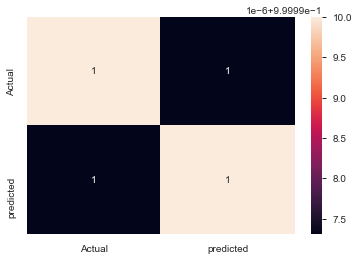

In [151]:
sns.heatmap(test_bagging[['Actual','predicted']].corr(),annot = True)

## Scatter plot

### Model is showing high accuracy as we are getting straight line with our actual and predicted values

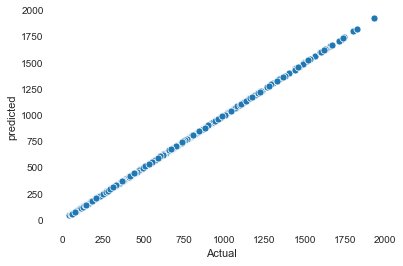

In [152]:
sns.scatterplot(test_bagging.Actual,test_bagging.predicted)

## Decile analysis

### We can see that outputs are good for almost every observation

In [153]:
test_bagging['Deciles'] = pd.qcut(test_bagging.predicted,10,labels = False)

In [156]:
test_bagging.groupby('Deciles')[['Actual','predicted']].mean().sort_index(ascending = False).reset_index()

,Deciles,Actual,predicted
0,9,1195.178312,1195.312463
1,8,759.957067,759.842366
2,7,598.900467,598.893306
3,6,513.904333,513.897232
4,5,441.837933,441.843824
5,4,383.339733,383.343169
6,3,328.121200,328.097775
7,2,282.074667,282.067781
8,1,227.530200,227.535589
9,0,135.538233,135.592135


<center>
<h1>Random Forest

In [157]:
from sklearn.ensemble import RandomForestRegressor

In [158]:
param_grid1={'n_estimators':[100,200,300,400],
'max_depth':np.arange(1,15),}

In [159]:
rndm_frst_reg = GridSearchCV(RandomForestRegressor(warm_start = True),param_grid1 , cv = 5)

In [160]:
rndm_frst_reg.fit(train[feature_columns2],train.log_spending)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=True),
             iid='deprecated', n_job

In [161]:
rndm_frst_reg.cv_results_

{'mean_fit_time': array([0.34309697, 0.66403952, 0.96741285, 1.27398601, 0.41668591,
        0.8236052 , 1.29234529, 1.63383217, 0.51282191, 1.03442583,
        1.52951918, 2.58288841, 0.61535497, 1.24288535, 1.86700907,
        2.54060826, 0.75199633, 1.4313673 , 2.28270431, 3.29239149,
        0.82379708, 1.63103957, 2.4769794 , 3.26666946, 0.94741917,
        2.37545872, 2.75785198, 3.84813914, 1.0424232 , 2.08143892,
        3.6460566 , 4.5049612 , 1.25863776, 2.51748061, 4.93131084,
        4.88754315, 1.38868804, 2.78038397, 4.76606226, 5.82223873,
        1.98587198, 3.64205718, 4.71818976, 6.62230606, 1.69666562,
        3.14059844, 5.22542644, 6.55487952, 1.50588417, 2.9994133 ,
        4.92006755, 6.04486375, 1.49922361, 3.06621957, 5.02798181,
        5.97965417]),
 'std_fit_time': array([0.04061388, 0.02560294, 0.07828578, 0.11089489, 0.00984144,
        0.00318585, 0.12111203, 0.00895179, 0.00614757, 0.00646188,
        0.00994526, 0.48934445, 0.00340209, 0.0170148 , 0.033

In [162]:
rndm_frst_reg.best_params_

{'max_depth': 12, 'n_estimators': 300}

In [163]:
rndm_frst_reg= RandomForestRegressor(max_depth=12,n_estimators=300)

In [164]:
rndm_frst_reg.fit(train[feature_columns2],train.log_spending)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## Predictions

In [165]:
train_random = pd.DataFrame({'Actual':train.spending,'predicted':np.exp(rndm_frst_reg.predict(train[feature_columns2]))})
test_random = pd.DataFrame({'Actual':test.spending,'predicted':np.exp(rndm_frst_reg.predict(test[feature_columns2]))})

In [168]:
test_random.head(5)

,Actual,predicted
3566,499.15,499.243530
4252,407.08,407.021773
1918,232.08,232.143007
4111,231.82,232.086617
1471,256.02,256.011727


In [169]:
train_random.head(5)

,Actual,predicted
2416,600.97,601.012374
2417,604.09,604.239822
2513,517.89,517.756272
1698,748.64,748.433470
3322,431.36,431.350194


## Mean errors

In [170]:
train_random[['Actual','predicted']].mean() ## No errors have been found 

Actual       494.620755
predicted    494.620113
dtype: float64

In [171]:
test_random[['Actual','predicted']].mean()

Actual       486.638215
predicted    486.652013
dtype: float64

## MSE AND RMSE

In [172]:
MSE_TRAIN_random = metrics.mean_squared_error(train_random.Actual,train_random.predicted)
MSE_TREST_random = metrics.mean_squared_error(test_random.Actual,test_random.predicted)

RMSE_TRAIN = np.sqrt(MSE_TRAIN_random)
RMSE_TEST= np.sqrt(MSE_TREST_random)

print('MSE_TRAIN',MSE_TRAIN_random,'|','MSE_TEST',MSE_TREST_random)
print('RMSE_TRAIN',RMSE_TRAIN,'|','RMSE_TEST',RMSE_TEST) ## Errors are high 

MSE_TRAIN 0.13118034314992724 | MSE_TEST 0.537449686510516
RMSE_TRAIN 0.362188270309693 | RMSE_TEST 0.7331096006127024
